<h1> Parameter Tunning 
    
    Look at epochs duration
    
    (6 months of data used)

# Importing libraries:

In [8]:
!pip install pandas
!pip install sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data; set X and y; fill nan values and split in test, training and validation data:

In [9]:

# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# for later use
features_num = 15

# 2018 data
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

# divide features and labels
X = data.iloc[:, 0:15] .values # turns it into an array
y = data.loc[:, 'Offers'].values # turns it into an array

from sklearn.model_selection import train_test_split

# divide data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size = 0.15, shuffle=False)

# divide data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.3, shuffle=False)

# Apply feature scaling:

In [10]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling 
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Importing the Keras libraries and packages:

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
import time

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []
time_count = []

# Prepare of data according to LSTM needs,  create regressor & tune:

In [12]:
# parameters
steps = 100
n_hidden = 1
units = 20
batch_size = 100

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# empty list to append metric values
mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Do tunning of epochs to understand how long it takes:

In [ ]:
epochs_range = [50, 75, 100, 125, 150, 200, 400]

for i in epochs_range:
    start_time = time.time()
    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_normal',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        for layer in list(reversed(range(n_hidden))):
            if layer == 0:
                model.add(LSTM(units = units, 
                               kernel_initializer = kernel_initializer,
                               bias_initializer = bias_initializer))
                model.add(LeakyReLU(alpha = 0.2))
                model.add(Dropout(0.2))
            else:
                model.add(LSTM(units = units, 
                               batch_input_shape = (batch_size, steps, features_num), 
                               stateful = True,
                               return_sequences = True,
                               kernel_initializer = kernel_initializer,
                               bias_initializer = bias_initializer))
                model.add(LeakyReLU(alpha = 0.2))
                model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = 'Adamax')
        return model

    model = regressor_tunning()

    # apply patience callback
    early_stopping = EarlyStopping(monitor='mse', patience=10)

    # fitting the LSTM to the training set
    history = model.fit(cut_data(X_train, batch_size),
                        cut_data(y_train, batch_size), 
                        batch_size = batch_size, 
                        epochs = i,
                        shuffle = False, 
                        validation_data = (cut_data(X_val, batch_size), cut_data(y_val, batch_size)),
                        callbacks = early_stopping)

    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)

    # make new predicitons with test set
    y_pred = model.predict(cut_data(X_test, batch_size), batch_size = batch_size)

    # plot the training progression
    #plt.plot(history.history['val_loss'], label = 'train')
    #plt.plot(history.history['val_loss'], label = 'test')
    #plt.legend()
    #plt.show()

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525

    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================

    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values


    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)


    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

Epoch 1/50
51/51 [==============================] - 7s 143ms/step - loss: 14606.7324 - mse: 14606.7314 - mae: 112.8509 - val_loss: 15769.4639 - val_mse: 15769.4639 - val_mae: 114.1771
Epoch 2/50
51/51 [==============================] - 5s 103ms/step - loss: 14154.3213 - mse: 14154.3213 - mae: 110.8120 - val_loss: 15638.6182 - val_mse: 15638.6182 - val_mae: 113.6057
Epoch 3/50
51/51 [==============================] - 5s 105ms/step - loss: 13934.4756 - mse: 13934.4756 - mae: 109.8009 - val_loss: 15578.1426 - val_mse: 15578.1426 - val_mae: 113.3420
Epoch 4/50
51/51 [==============================] - 5s 93ms/step - loss: 13796.2637 - mse: 13796.2637 - mae: 109.1739 - val_loss: 15530.0723 - val_mse: 15530.0723 - val_mae: 113.1307
Epoch 5/50
51/51 [==============================] - 5s 100ms/step - loss: 13650.3594 - mse: 13650.3594 - mae: 108.5036 - val_loss: 15485.1934 - val_mse: 15485.1934 - val_mae: 112.9332
Epoch 6/50
51/51 [==============================] - 5s 98ms/step - loss: 13531.92

51/51 [==============================] - 5s 104ms/step - loss: 9907.6719 - mse: 9907.6719 - mae: 89.5456 - val_loss: 14324.5322 - val_mse: 14324.5322 - val_mae: 107.7175
Epoch 46/50
51/51 [==============================] - 5s 93ms/step - loss: 9821.1328 - mse: 9821.1328 - mae: 89.0885 - val_loss: 14301.8584 - val_mse: 14301.8584 - val_mae: 107.6132
Epoch 47/50
51/51 [==============================] - 5s 104ms/step - loss: 9737.3525 - mse: 9737.3525 - mae: 88.6471 - val_loss: 14278.6133 - val_mse: 14278.6123 - val_mae: 107.5061
Epoch 48/50
51/51 [==============================] - 5s 99ms/step - loss: 9674.3994 - mse: 9674.3994 - mae: 88.2108 - val_loss: 14255.8545 - val_mse: 14255.8545 - val_mae: 107.4011
Epoch 49/50
51/51 [==============================] - 5s 95ms/step - loss: 9569.0225 - mse: 9569.0225 - mae: 87.6883 - val_loss: 14234.1748 - val_mse: 14234.1748 - val_mae: 107.3007
Epoch 50/50
51/51 [==============================] - 6s 114ms/step - loss: 9499.7471 - mse: 9499.7471 - m

Epoch 40/75
51/51 [==============================] - 6s 109ms/step - loss: 9950.5928 - mse: 9950.5928 - mae: 89.8104 - val_loss: 11730.5771 - val_mse: 11730.5771 - val_mae: 94.7370
Epoch 41/75
51/51 [==============================] - 5s 99ms/step - loss: 9837.3887 - mse: 9837.3887 - mae: 89.1926 - val_loss: 11645.8301 - val_mse: 11645.8301 - val_mae: 94.2867
Epoch 42/75
51/51 [==============================] - 4s 80ms/step - loss: 9724.6660 - mse: 9724.6660 - mae: 88.5629 - val_loss: 11558.8105 - val_mse: 11558.8105 - val_mae: 93.8259
Epoch 43/75
51/51 [==============================] - 4s 80ms/step - loss: 9655.0625 - mse: 9655.0625 - mae: 88.1249 - val_loss: 11472.7715 - val_mse: 11472.7715 - val_mae: 93.3659
Epoch 44/75
51/51 [==============================] - 5s 90ms/step - loss: 9540.5850 - mse: 9540.5850 - mae: 87.5208 - val_loss: 11388.2734 - val_mse: 11388.2734 - val_mae: 92.9078
Epoch 45/75
51/51 [==============================] - 5s 100ms/step - loss: 9448.9492 - mse: 9448.95

51/51 [==============================] - 5s 97ms/step - loss: 13256.1494 - mse: 13256.1494 - mae: 106.6756 - val_loss: 14633.0938 - val_mse: 14633.0957 - val_mae: 109.0682
Epoch 11/100
51/51 [==============================] - 5s 98ms/step - loss: 13152.2637 - mse: 13152.2637 - mae: 106.1915 - val_loss: 14555.5029 - val_mse: 14555.5010 - val_mae: 108.7112
Epoch 12/100
51/51 [==============================] - 5s 96ms/step - loss: 13066.4551 - mse: 13066.4551 - mae: 105.7694 - val_loss: 14475.3154 - val_mse: 14475.3154 - val_mae: 108.3392
Epoch 13/100
51/51 [==============================] - 6s 108ms/step - loss: 12957.5732 - mse: 12957.5732 - mae: 105.2610 - val_loss: 14393.6973 - val_mse: 14393.6973 - val_mae: 107.9609
Epoch 14/100
51/51 [==============================] - 6s 117ms/step - loss: 12862.1553 - mse: 12862.1553 - mae: 104.8106 - val_loss: 14314.0195 - val_mse: 14314.0195 - val_mae: 107.5885
Epoch 15/100
51/51 [==============================] - 5s 99ms/step - loss: 12770.1387 

51/51 [==============================] - 7s 134ms/step - loss: 9309.2607 - mse: 9309.2607 - mae: 86.1755 - val_loss: 11350.2363 - val_mse: 11350.2363 - val_mae: 92.5626
Epoch 55/100
51/51 [==============================] - 7s 136ms/step - loss: 9206.0205 - mse: 9206.0205 - mae: 85.5672 - val_loss: 11276.2920 - val_mse: 11276.2920 - val_mae: 92.1510
Epoch 56/100
51/51 [==============================] - 6s 122ms/step - loss: 9147.4951 - mse: 9147.4951 - mae: 85.2395 - val_loss: 11209.0117 - val_mse: 11209.0117 - val_mae: 91.7780
Epoch 57/100
51/51 [==============================] - 7s 139ms/step - loss: 9061.4287 - mse: 9061.4287 - mae: 84.6959 - val_loss: 11140.9590 - val_mse: 11140.9590 - val_mae: 91.4004
Epoch 58/100
51/51 [==============================] - 7s 132ms/step - loss: 8984.4912 - mse: 8984.4912 - mae: 84.2484 - val_loss: 11071.8838 - val_mse: 11071.8838 - val_mae: 91.0138
Epoch 59/100
51/51 [==============================] - 7s 143ms/step - loss: 8893.3008 - mse: 8893.3008 

51/51 [==============================] - 6s 109ms/step - loss: 13524.3887 - mse: 13524.3887 - mae: 107.9202 - val_loss: 14863.2227 - val_mse: 14863.2217 - val_mae: 110.1469
Epoch 8/125
51/51 [==============================] - 5s 95ms/step - loss: 13393.0303 - mse: 13393.0303 - mae: 107.3174 - val_loss: 14755.5518 - val_mse: 14755.5518 - val_mae: 109.6592
Epoch 9/125
51/51 [==============================] - 5s 107ms/step - loss: 13264.9033 - mse: 13264.9033 - mae: 106.7156 - val_loss: 14648.9990 - val_mse: 14648.9990 - val_mae: 109.1746
Epoch 10/125
51/51 [==============================] - 5s 99ms/step - loss: 13141.6152 - mse: 13141.6152 - mae: 106.1268 - val_loss: 14544.2559 - val_mse: 14544.2559 - val_mae: 108.6949
Epoch 11/125
51/51 [==============================] - 5s 108ms/step - loss: 13022.6279 - mse: 13022.6279 - mae: 105.5809 - val_loss: 14440.5391 - val_mse: 14440.5391 - val_mae: 108.2188
Epoch 12/125
51/51 [==============================] - 5s 93ms/step - loss: 12895.6777 -

Epoch 52/125
51/51 [==============================] - 5s 90ms/step - loss: 8755.5898 - mse: 8755.5898 - mae: 82.8829 - val_loss: 10771.7109 - val_mse: 10771.7109 - val_mae: 89.7588
Epoch 53/125
51/51 [==============================] - 6s 110ms/step - loss: 8677.9082 - mse: 8677.9082 - mae: 82.3859 - val_loss: 10692.1113 - val_mse: 10692.1113 - val_mae: 89.3172
Epoch 54/125
51/51 [==============================] - 5s 89ms/step - loss: 8571.7666 - mse: 8571.7666 - mae: 81.7744 - val_loss: 10613.3037 - val_mse: 10613.3037 - val_mae: 88.8772
Epoch 55/125
51/51 [==============================] - 5s 102ms/step - loss: 8499.0840 - mse: 8499.0840 - mae: 81.3141 - val_loss: 10535.4336 - val_mse: 10535.4336 - val_mae: 88.4400
Epoch 56/125
51/51 [==============================] - 5s 97ms/step - loss: 8417.7207 - mse: 8417.7207 - mae: 80.8287 - val_loss: 10458.8496 - val_mse: 10458.8496 - val_mae: 88.0068
Epoch 57/125
51/51 [==============================] - 5s 93ms/step - loss: 8310.2070 - mse: 8

51/51 [==============================] - 6s 125ms/step - loss: 5502.5132 - mse: 5502.5132 - mae: 60.1265 - val_loss: 8104.9922 - val_mse: 8104.9922 - val_mae: 73.5678
Epoch 98/125
51/51 [==============================] - 6s 110ms/step - loss: 5404.8594 - mse: 5404.8594 - mae: 59.2783 - val_loss: 8052.8760 - val_mse: 8052.8760 - val_mae: 73.2159
Epoch 99/125
51/51 [==============================] - 6s 114ms/step - loss: 5383.6377 - mse: 5383.6377 - mae: 58.9763 - val_loss: 7998.2935 - val_mse: 7998.2935 - val_mae: 72.8437
Epoch 100/125
51/51 [==============================] - 5s 90ms/step - loss: 5325.3101 - mse: 5325.3101 - mae: 58.5949 - val_loss: 7945.1279 - val_mse: 7945.1279 - val_mae: 72.4819
Epoch 101/125
51/51 [==============================] - 6s 113ms/step - loss: 5284.8433 - mse: 5284.8433 - mae: 58.2592 - val_loss: 7891.6714 - val_mse: 7891.6714 - val_mae: 72.1147
Epoch 102/125
51/51 [==============================] - 5s 106ms/step - loss: 5199.7988 - mse: 5199.7988 - mae: 5

51/51 [==============================] - 6s 124ms/step - loss: 12889.8350 - mse: 12889.8350 - mae: 104.9410 - val_loss: 15358.3584 - val_mse: 15358.3584 - val_mae: 112.3791
Epoch 18/150
51/51 [==============================] - 6s 120ms/step - loss: 12790.4434 - mse: 12790.4434 - mae: 104.4536 - val_loss: 15343.2754 - val_mse: 15343.2754 - val_mae: 112.3130
Epoch 19/150
51/51 [==============================] - 10s 192ms/step - loss: 12701.0889 - mse: 12701.0889 - mae: 104.0300 - val_loss: 15328.5303 - val_mse: 15328.5303 - val_mae: 112.2492
Epoch 20/150
51/51 [==============================] - 8s 153ms/step - loss: 12602.7900 - mse: 12602.7900 - mae: 103.5707 - val_loss: 15314.0215 - val_mse: 15314.0215 - val_mae: 112.1889
Epoch 21/150
51/51 [==============================] - 8s 149ms/step - loss: 12510.8066 - mse: 12510.8066 - mae: 103.1277 - val_loss: 15301.4258 - val_mse: 15301.4258 - val_mae: 112.1360
Epoch 22/150
51/51 [==============================] - 6s 125ms/step - loss: 12414.

51/51 [==============================] - 6s 121ms/step - loss: 9199.6641 - mse: 9199.6641 - mae: 85.5559 - val_loss: 14866.7041 - val_mse: 14866.7041 - val_mae: 110.3459
Epoch 62/150
51/51 [==============================] - 7s 136ms/step - loss: 9129.7949 - mse: 9129.7949 - mae: 85.1039 - val_loss: 14855.0029 - val_mse: 14855.0029 - val_mae: 110.2952
Epoch 63/150
51/51 [==============================] - 6s 124ms/step - loss: 9069.6035 - mse: 9069.6035 - mae: 84.7100 - val_loss: 14842.2725 - val_mse: 14842.2725 - val_mae: 110.2408
Epoch 64/150
51/51 [==============================] - 6s 126ms/step - loss: 9002.6094 - mse: 9002.6094 - mae: 84.3677 - val_loss: 14831.0000 - val_mse: 14830.9990 - val_mae: 110.1917
Epoch 65/150
51/51 [==============================] - 7s 130ms/step - loss: 8905.1436 - mse: 8905.1436 - mae: 83.8054 - val_loss: 14816.8574 - val_mse: 14816.8574 - val_mae: 110.1315
Epoch 66/150
51/51 [==============================] - 7s 134ms/step - loss: 8857.1650 - mse: 8857.

Epoch 6/200
51/51 [==============================] - 7s 140ms/step - loss: 13579.0938 - mse: 13579.0938 - mae: 108.1777 - val_loss: 14918.2500 - val_mse: 14918.2500 - val_mae: 110.3835
Epoch 7/200
51/51 [==============================] - 7s 130ms/step - loss: 13470.0820 - mse: 13470.0820 - mae: 107.6743 - val_loss: 14825.3799 - val_mse: 14825.3799 - val_mae: 109.9621
Epoch 8/200
51/51 [==============================] - 7s 132ms/step - loss: 13354.7090 - mse: 13354.7090 - mae: 107.1352 - val_loss: 14733.5039 - val_mse: 14733.5039 - val_mae: 109.5440
Epoch 9/200
51/51 [==============================] - 8s 148ms/step - loss: 13244.3232 - mse: 13244.3232 - mae: 106.6163 - val_loss: 14644.5312 - val_mse: 14644.5312 - val_mae: 109.1378
Epoch 10/200
51/51 [==============================] - 7s 138ms/step - loss: 13128.3564 - mse: 13128.3564 - mae: 106.0704 - val_loss: 14557.0547 - val_mse: 14557.0547 - val_mae: 108.7369
Epoch 11/200
51/51 [==============================] - 7s 143ms/step - loss

Epoch 79/200
51/51 [==============================] - 7s 135ms/step - loss: 6835.8652 - mse: 6835.8652 - mae: 70.3290 - val_loss: 10209.5703 - val_mse: 10209.5703 - val_mae: 86.5864
Epoch 80/200
51/51 [==============================] - 7s 133ms/step - loss: 6741.2368 - mse: 6741.2368 - mae: 69.6733 - val_loss: 10157.8105 - val_mse: 10157.8105 - val_mae: 86.2888
Epoch 81/200
51/51 [==============================] - 7s 137ms/step - loss: 6699.8237 - mse: 6699.8237 - mae: 69.3000 - val_loss: 10106.5088 - val_mse: 10106.5088 - val_mae: 85.9930
Epoch 82/200
51/51 [==============================] - 7s 136ms/step - loss: 6630.4141 - mse: 6630.4141 - mae: 68.7741 - val_loss: 10054.1641 - val_mse: 10054.1641 - val_mae: 85.6904
Epoch 83/200
51/51 [==============================] - 6s 121ms/step - loss: 6548.0015 - mse: 6548.0015 - mae: 68.1886 - val_loss: 10001.6162 - val_mse: 10001.6162 - val_mae: 85.3858
Epoch 84/200
51/51 [==============================] - 6s 117ms/step - loss: 6469.8218 - ms

51/51 [==============================] - 7s 132ms/step - loss: 2962.4280 - mse: 2962.4280 - mae: 34.2288 - val_loss: 6692.7744 - val_mse: 6692.7744 - val_mae: 63.2050
Epoch 171/200
51/51 [==============================] - 7s 130ms/step - loss: 2918.3271 - mse: 2918.3271 - mae: 33.9450 - val_loss: 6665.5435 - val_mse: 6665.5435 - val_mae: 62.9904
Epoch 172/200
51/51 [==============================] - 7s 133ms/step - loss: 2909.1243 - mse: 2909.1243 - mae: 33.8456 - val_loss: 6638.6411 - val_mse: 6638.6411 - val_mae: 62.7774
Epoch 173/200
51/51 [==============================] - 7s 131ms/step - loss: 2892.8594 - mse: 2892.8594 - mae: 33.5612 - val_loss: 6611.9507 - val_mse: 6611.9507 - val_mae: 62.5654
Epoch 174/200
51/51 [==============================] - 7s 138ms/step - loss: 2865.5771 - mse: 2865.5771 - mae: 33.0925 - val_loss: 6585.6421 - val_mse: 6585.6421 - val_mae: 62.3560
Epoch 175/200
51/51 [==============================] - 7s 131ms/step - loss: 2863.0608 - mse: 2863.0608 - mae

Epoch 130/400
51/51 [==============================] - 7s 141ms/step - loss: 3419.1487 - mse: 3419.1487 - mae: 39.4940 - val_loss: 8694.7627 - val_mse: 8694.7627 - val_mae: 76.8042
Epoch 131/400
51/51 [==============================] - 7s 139ms/step - loss: 3346.6787 - mse: 3346.6787 - mae: 39.0049 - val_loss: 8661.5674 - val_mse: 8661.5674 - val_mae: 76.5807
Epoch 132/400
51/51 [==============================] - 7s 141ms/step - loss: 3321.6062 - mse: 3321.6062 - mae: 38.5891 - val_loss: 8629.4209 - val_mse: 8629.4209 - val_mae: 76.3658
Epoch 133/400
51/51 [==============================] - 7s 129ms/step - loss: 3285.3596 - mse: 3285.3596 - mae: 38.4425 - val_loss: 8597.5449 - val_mse: 8597.5449 - val_mae: 76.1511
Epoch 134/400
51/51 [==============================] - 6s 119ms/step - loss: 3291.8499 - mse: 3291.8499 - mae: 38.0118 - val_loss: 8567.2578 - val_mse: 8567.2578 - val_mae: 75.9463
Epoch 135/400
51/51 [==============================] - 6s 109ms/step - loss: 3236.0071 - mse: 3

# Save results into a data frame

In [ ]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count}, index = epochs_range)



In [15]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
50,87.832379,81.388683,84.813832,78.888267,88.264840,81.754074,272.893739
75,72.873456,64.962537,69.796481,62.462150,73.312286,65.327923,392.874248
100,68.402432,59.903951,65.308482,57.403566,68.842913,60.269337,583.531922
125,52.563794,40.923884,49.439947,38.396354,53.004873,41.293236,2934.840515
150,55.243666,44.301756,52.117733,41.787914,55.685771,44.669109,1054.707169
200,36.705460,19.074674,33.956029,16.725385,37.090176,19.417980,1437.172979
400,33.029733,19.843288,31.194747,18.487787,33.289413,20.041369,1708.203789


In [16]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


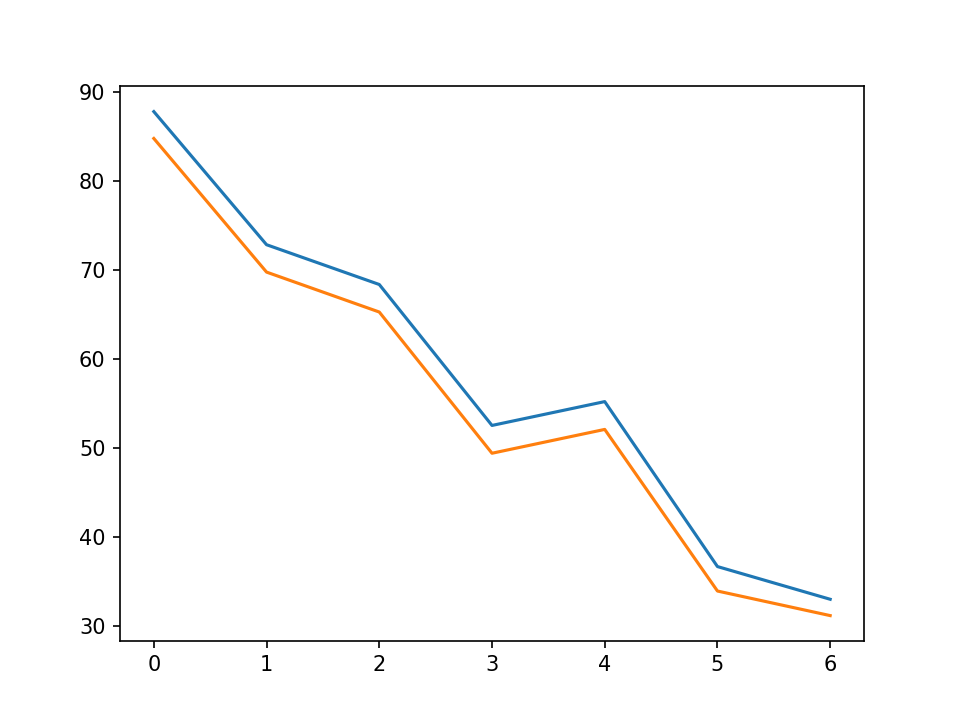

In [22]:
plt.plot(rmse_gen)
plt.plot(rmse_spi)
plt.plot(rmse_)